In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle

#Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset
data = pd.read_csv('train_news.csv')
print(data.shape)
data.head()

(20800, 6)


,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [3]:
# Dataset has extra columns- Remove 
data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
#Checking the information of the datset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          20800 non-null  int64 
 1   headline    20242 non-null  object
 2   written_by  18843 non-null  object
 3   news        20761 non-null  object
 4   label       20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
#Checking the missing values in the dataset
data.isnull().values.any()

True

In [6]:
#Checking the number of missing values according to column wise
data.isnull().sum()

id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64

In [7]:
# Dataset has extra columns- Remove 
data.drop(columns=['id','headline','written_by'],axis=1,inplace=True)

In [8]:
data.head()

,news,label
0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,HOUSTON — Venezuela had a plan. It was a ta...,0
2,"Sunday on ABC’s “This Week,” while discussing ...",0
3,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,Finian Cunningham has written extensively on...,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    20761 non-null  object
 1   label   20800 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


In [10]:
print('Columns having missing values are as follows:')
for i in data.isnull().any().index:
    if (data.isnull().any()[i]):
        print(i)

Columns having missing values are as follows:
news


In [11]:
print("Number of missing values in each column:")
print(data.isnull().sum())
print('\nPercentage of missing values in each column:')
print(round(100*data.isnull().sum()/len(data.index)),2)

Number of missing values in each column:
news     39
label     0
dtype: int64

Percentage of missing values in each column:
news     0.0
label    0.0
dtype: float64 2


In [12]:
data.isnull().sum()

news     39
label     0
dtype: int64

In [13]:
# Let's drop null values
print('Initial Shape ::', data.shape)
data.dropna(axis=0, how='any', inplace=True)
print('Final Shape ::', data.shape)

Initial Shape :: (20800, 2)
Final Shape :: (20761, 2)


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    20761 non-null  object
 1   label   20761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.6+ KB


In [15]:
#No null values, Label encode sentiment to 1(positive) and 0(negative)
data.label.value_counts()

0    10387
1    10374
Name: label, dtype: int64

Remark:- Here 1 stands for Fake News and 0 stands for real news


In [16]:
#Checking the Ratio of the Labels
print("Real News Ratio:",round(len(data[data['label']==0])/len(data['label']),2)*100,'%')
print("Fake News Ratio:",round(len(data[data['label']==1])/len(data['label']),2)*100,'%')

Real News Ratio: 50.0 %
Fake News Ratio: 50.0 %


Finding:- Dataset is balanced so not need to balance for Model Building.
    

In [17]:
data.news[0]

'WASHINGTON  —   In Sonny Perdue’s telling, Georgians were growing weary of the corruption and scandals in their state when he took over as governor in 2003  —   a time when he gave his own version of a “drain the swamp” pledge. “My first goal as governor is to restore public trust in state government by changing the culture of state government,” Mr. Perdue told a leadership conference at Kennesaw State University in April 2003. “Our form of government depends on a mutual bond of trust between the people and their government. But people have become cynical about their government. ” But Mr. Perdue, a Republican who is awaiting confirmation to serve as President Trump’s agriculture secretary, became a target of frequent criticism that he was failing to honor his own ethics pledge during his eight years as governor. The criticism centers on the fact that, as Mr. Trump has, he continued to own or help run his family business ventures  —   four   companies  —   while serving as governor. Mr

In [19]:
#Creating the new column which is news_length before cleaning the news

data['news_length'] = data['news'].str.len()
data.head()

,news,label,news_length
0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,7936
1,HOUSTON — Venezuela had a plan. It was a ta...,0,6112
2,"Sunday on ABC’s “This Week,” while discussing ...",0,425
3,"AUGUSTA, Me. — The beleaguered Republican g...",0,6516
4,Finian Cunningham has written extensively on...,1,9164


## Data Cleaning Steps for news column
Remove HTML tags

Remove special characters

Convert everything to lowercase

Remove stopwords

Stemming

In [20]:
# 1. Remove HTML tags
#Regex rule : ‘<.*?>’

def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text) # substring replace with ''(space)

data.news = data.news.apply(clean)
data.news[0]

'WASHINGTON  —   In Sonny Perdue’s telling, Georgians were growing weary of the corruption and scandals in their state when he took over as governor in 2003  —   a time when he gave his own version of a “drain the swamp” pledge. “My first goal as governor is to restore public trust in state government by changing the culture of state government,” Mr. Perdue told a leadership conference at Kennesaw State University in April 2003. “Our form of government depends on a mutual bond of trust between the people and their government. But people have become cynical about their government. ” But Mr. Perdue, a Republican who is awaiting confirmation to serve as President Trump’s agriculture secretary, became a target of frequent criticism that he was failing to honor his own ethics pledge during his eight years as governor. The criticism centers on the fact that, as Mr. Trump has, he continued to own or help run his family business ventures  —   four   companies  —   while serving as governor. Mr

In [21]:
# 2. Remove special characters
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

data.news = data.news.apply(is_special)
data.news[0]

'WASHINGTON      In Sonny Perdue s telling  Georgians were growing weary of the corruption and scandals in their state when he took over as governor in 2003      a time when he gave his own version of a  drain the swamp  pledge   My first goal as governor is to restore public trust in state government by changing the culture of state government   Mr  Perdue told a leadership conference at Kennesaw State University in April 2003   Our form of government depends on a mutual bond of trust between the people and their government  But people have become cynical about their government    But Mr  Perdue  a Republican who is awaiting confirmation to serve as President Trump s agriculture secretary  became a target of frequent criticism that he was failing to honor his own ethics pledge during his eight years as governor  The criticism centers on the fact that  as Mr  Trump has  he continued to own or help run his family business ventures      four   companies      while serving as governor  Mr

In [22]:
# 3. Convert everything to lowercase
def to_lower(text):
    return text.lower()

data.news = data.news.apply(to_lower)
data.news[0]

'washington      in sonny perdue s telling  georgians were growing weary of the corruption and scandals in their state when he took over as governor in 2003      a time when he gave his own version of a  drain the swamp  pledge   my first goal as governor is to restore public trust in state government by changing the culture of state government   mr  perdue told a leadership conference at kennesaw state university in april 2003   our form of government depends on a mutual bond of trust between the people and their government  but people have become cynical about their government    but mr  perdue  a republican who is awaiting confirmation to serve as president trump s agriculture secretary  became a target of frequent criticism that he was failing to honor his own ethics pledge during his eight years as governor  the criticism centers on the fact that  as mr  trump has  he continued to own or help run his family business ventures      four   companies      while serving as governor  mr

In [23]:
# 4. Remove stopwords
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

data.news = data.news.apply(rem_stopwords)
data.news[0]

['washington',
 'sonny',
 'perdue',
 'telling',
 'georgians',
 'growing',
 'weary',
 'corruption',
 'scandals',
 'state',
 'took',
 'governor',
 '2003',
 'time',
 'gave',
 'version',
 'drain',
 'swamp',
 'pledge',
 'first',
 'goal',
 'governor',
 'restore',
 'public',
 'trust',
 'state',
 'government',
 'changing',
 'culture',
 'state',
 'government',
 'mr',
 'perdue',
 'told',
 'leadership',
 'conference',
 'kennesaw',
 'state',
 'university',
 'april',
 '2003',
 'form',
 'government',
 'depends',
 'mutual',
 'bond',
 'trust',
 'people',
 'government',
 'people',
 'become',
 'cynical',
 'government',
 'mr',
 'perdue',
 'republican',
 'awaiting',
 'confirmation',
 'serve',
 'president',
 'trump',
 'agriculture',
 'secretary',
 'became',
 'target',
 'frequent',
 'criticism',
 'failing',
 'honor',
 'ethics',
 'pledge',
 'eight',
 'years',
 'governor',
 'criticism',
 'centers',
 'fact',
 'mr',
 'trump',
 'continued',
 'help',
 'run',
 'family',
 'business',
 'ventures',
 'four',
 'compani

In [24]:
# Stemming

def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

data.news = data.news.apply(stem_txt)

data.news[0]

'washington sonni perdu tell georgian grow weari corrupt scandal state took governor 2003 time gave version drain swamp pledg first goal governor restor public trust state govern chang cultur state govern mr perdu told leadership confer kennesaw state univers april 2003 form govern depend mutual bond trust peopl govern peopl becom cynic govern mr perdu republican await confirm serv presid trump agricultur secretari becam target frequent critic fail honor ethic pledg eight year governor critic center fact mr trump continu help run famili busi ventur four compani serv governor mr perdu one last cabinet member await senat confirm date set confirm hear holdup releas paperwork accompani nomin feder offic govern ethic blame delay offic must examin mr perdu propos avoid conflict interest run u depart known may includ sell farm asset tenur governor end 2011 13 complaint file mr perdu state ethic commiss two occas rule governor violat state ethic law commiss took unusu step fine mr perdu govern

In [25]:
# Creating new column (clean_length) after removing puncuations,stopwords from news column to check how much data is cleaned
data['clean_news_length'] = data.news.str.len()
data.head()

,news,label,news_length,clean_news_length
0,washington sonni perdu tell georgian grow wear...,0,7936,4644
1,houston venezuela plan tactic approach design ...,0,6112,3725
2,sunday abc week discuss republican plan repeal...,0,425,238
3,augusta beleagu republican governor main seem ...,0,6516,3809
4,finian cunningham written extens intern affair...,1,9164,5786


In [26]:
#Total length removal
print("Origional Length:",data.news_length.sum())
print("Cleaned Length:",data.clean_news_length.sum())
print("Total Words Removed:",(data.news_length.sum()) - (data.clean_news_length.sum()))

Origional Length: 94518924
Cleaned Length: 56811996
Total Words Removed: 37706928


Observation:- Here we see the difference between origional length of news column and cleaned length of news column.
    

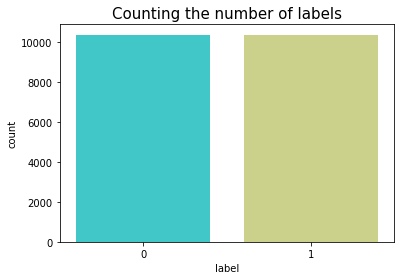

0    10387
1    10374
Name: label, dtype: int64


In [27]:
# Plotting the count of label.

plt.figure(figsize=(6,4))
sns.countplot(data['label'],palette= 'rainbow')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print(data.label.value_counts())

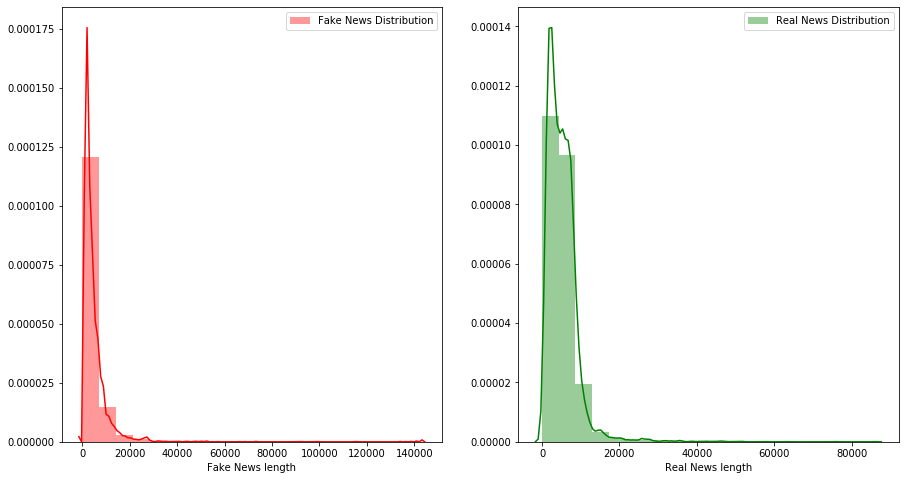

In [28]:
# Plotting the distribution of news  before cleaning news

f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(data[data['label']==1]['news_length'],bins=20, ax=ax[0],label='Fake News Distribution',color='r')
ax[0].set_xlabel('Fake News length')
ax[0].legend()

sns.distplot(data[data['label']==0]['news_length'],bins=20, ax=ax[1],label='Real News Distribution',color='g')
ax[1].set_xlabel('Real News length')
ax[1].legend()

plt.show()

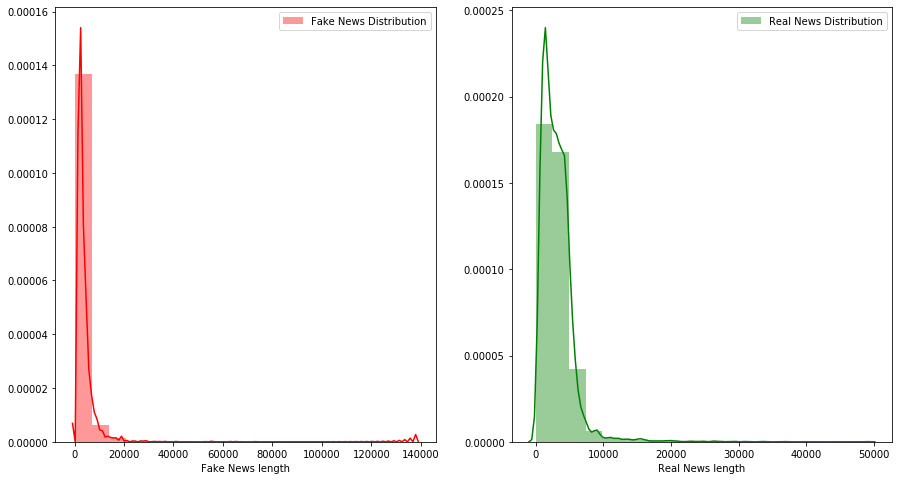

In [29]:
# Plotting the distribution of news  after cleaning news

f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(data[data['label']==1]['clean_news_length'],bins=20, ax=ax[0],label='Fake News Distribution',color='r')
ax[0].set_xlabel('Fake News length')
ax[0].legend()

sns.distplot(data[data['label']==0]['clean_news_length'],bins=20, ax=ax[1],label='Real News Distribution',color='g')
ax[1].set_xlabel('Real News length')
ax[1].legend()

plt.show()

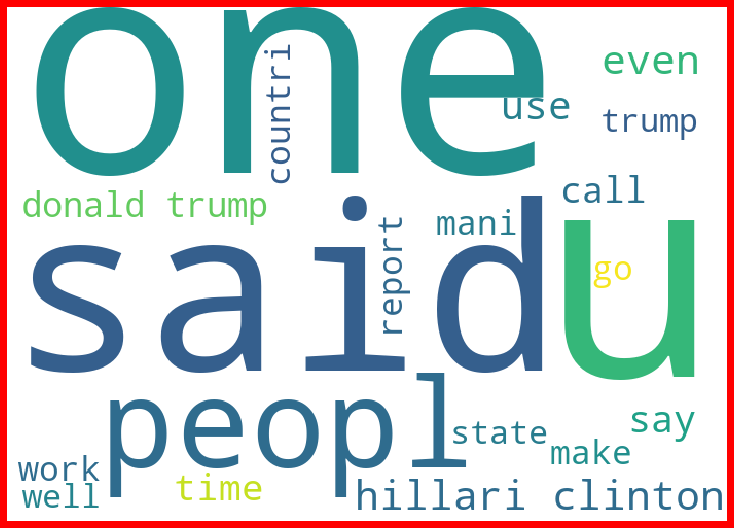

In [30]:
#Getting sense of loud words in Fake News

from wordcloud import WordCloud


spams = data['news'][data['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

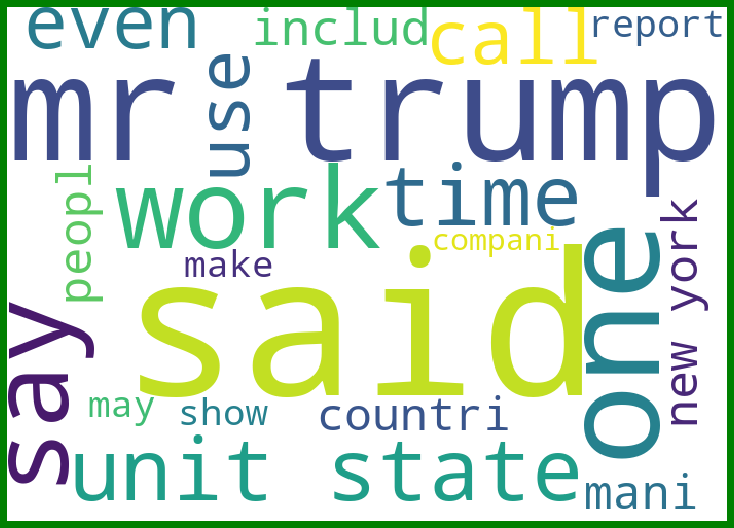

In [31]:
#Getting sense of loud words in Real News

from wordcloud import WordCloud


not_spams = data['news'][data['label']==0]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [32]:
data.head()

,news,label,news_length,clean_news_length
0,washington sonni perdu tell georgian grow wear...,0,7936,4644
1,houston venezuela plan tactic approach design ...,0,6112,3725
2,sunday abc week discuss republican plan repeal...,0,425,238
3,augusta beleagu republican governor main seem ...,0,6516,3809
4,finian cunningham written extens intern affair...,1,9164,5786


## Converting the text into vectors using TF-IDF Vectorizer

In [33]:
# Importing the library and converting it into vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer()

#Independent Features
X = tf_vec.fit_transform(data['news'])

In [34]:
# Dependent Feature
y = data['label']

In [35]:
## Divide the dataset into Train and Test

from sklearn.model_selection import train_test_split

X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

## Multinomial NB

Final score => 0.8930841841649008

 [[2463  163]
 [ 392 2173]]


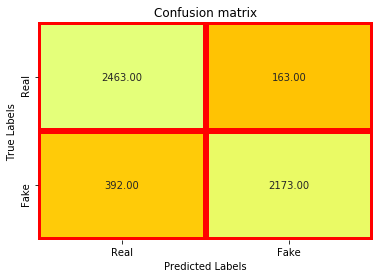

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2626
           1       0.93      0.85      0.89      2565

    accuracy                           0.89      5191
   macro avg       0.90      0.89      0.89      5191
weighted avg       0.90      0.89      0.89      5191



In [36]:
# Importing the library and Training the model
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB(alpha=0)
naive.fit(X_train,Y_train)

#Making Prediction
y_pred = naive.predict(x_test)

#Printing the Metrics
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
#Accuracy Score
print('Final score =>', accuracy_score(y_test,y_pred))

#Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
print("\n",conf_mat)

# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0,fmt='.2f',cbar=False,cmap = 'Wistia_r')

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])
plt.show()

#Classification Report
print(classification_report(y_test, y_pred))

## Passive Aggressive Classifier Algorithm

Accuracy: 0.957

 [[2511  115]
 [ 107 2458]]


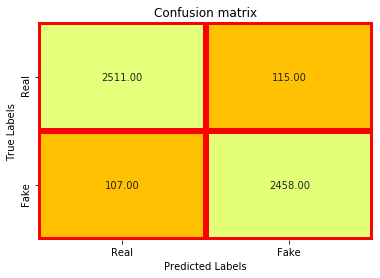

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2626
           1       0.96      0.96      0.96      2565

    accuracy                           0.96      5191
   macro avg       0.96      0.96      0.96      5191
weighted avg       0.96      0.96      0.96      5191



In [37]:
# Importing the Linrary
from sklearn.linear_model import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier( validation_fraction=0.25,C=3, max_iter=1000, random_state=42, 
                                   n_iter_no_change=8,
                                   shuffle=True,
                                   loss='hinge',
                                   n_jobs=-1)

#Training the model
pac.fit(X_train,Y_train)

#Makeing prediction
pred = pac.predict(x_test)

#Accuracy
score = accuracy_score(y_test,pred)
print("Accuracy: %0.3f" %score)

#Confusion Matrix
cm = confusion_matrix(y_test,pred)
print('\n',cm)

# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0,fmt='.2f',cbar=False,cmap = 'Wistia_r')

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])
plt.show()

#Classification Report
print(classification_report(y_test, pred))

In [38]:
# Get Features names for passive aggressive classifier
feature_names = tf_vec.get_feature_names()

In [39]:
pac.coef_[0]

array([ 0.2646885 ,  0.31069062, -0.08176454, ...,  0.01447613,
       -0.03559581,  0.        ])

In [40]:
#  Seeing the Most real words in our news column
sorted(zip(pac.coef_[0], feature_names), reverse=True)[:20]

[(8.817834015370924, 'anti'),
 (7.252731628158394, '2016'),
 (7.076581638046668, 'octob'),
 (6.980707120561513, 'non'),
 (6.409612468781956, 'novemb'),
 (6.0580801925102925, 'self'),
 (6.0334057142160615, 'co'),
 (4.99764215568233, 'share'),
 (4.877093686416111, 'hillari'),
 (4.84505884737072, 'old'),
 (4.472384273871379, 'al'),
 (4.302771677997087, 'via'),
 (4.2400223614111585, 'snip'),
 (4.209187185186815, 'howev'),
 (4.144743633855878, 'sourc'),
 (4.116899981344595, 'comment'),
 (4.087155053370935, 'articl'),
 (3.95747414264031, 'us'),
 (3.9082480699458535, '11'),
 (3.6788016747106806, 'print')]

In [41]:
### Seeing the Most fake words in our news column
sorted(zip(pac.coef_[0], feature_names))[:20]

[(-8.902656271927336, 'breitbart'),
 (-8.546319805015713, 'twitter'),
 (-7.98195340662176, 'said'),
 (-6.511801062394126, 'mr'),
 (-6.4594848345113345, '2017'),
 (-5.2407124254976, 'follow'),
 (-5.131521803708904, 'ms'),
 (-4.222305387847402, 'saturday'),
 (-4.064947221097855, 'inaugur'),
 (-3.979230586599701, 'mrs'),
 (-3.8220226995979134, 'jeff'),
 (-3.75807092962717, 'sunday'),
 (-3.3625275456767607, 'administr'),
 (-3.360501310211567, 'milo'),
 (-3.2505218607971917, 'pamkeynen'),
 (-3.2199340654011084, 'app'),
 (-3.1718210779371057, 'march'),
 (-3.1249780202138653, 'macron'),
 (-3.092384573538873, 'mondal'),
 (-3.0658831975487395, 'dr')]

## Converting the Text using HashingVectorizer

In [42]:
# Importing the library and converting it into vectors
from sklearn.feature_extraction.text import HashingVectorizer
hs_vectorizer=HashingVectorizer(n_features=30000, binary=bool)

# Independent Features
X = hs_vectorizer.fit_transform(data['news']).toarray()

In [43]:
#Checking the shape of the independent features
X.shape

(20761, 30000)

In [44]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
# Dependent Features
y = data['label']

In [46]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Final score => 0.8741371006582116


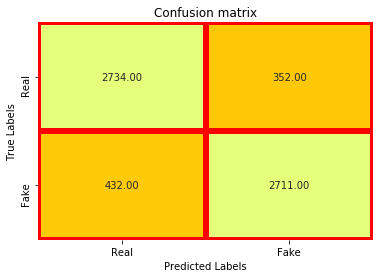

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3086
           1       0.89      0.86      0.87      3143

    accuracy                           0.87      6229
   macro avg       0.87      0.87      0.87      6229
weighted avg       0.87      0.87      0.87      6229



In [47]:
# Train the model
from sklearn.naive_bayes import MultinomialNB
naive = MultinomialNB(alpha=0)
naive.fit(X_train,y_train)

#Making Prediction
y_pred = naive.predict(X_test)

#Printing the Metrics
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
#Accuracy Score
print('Final score =>', accuracy_score(y_test,y_pred))

# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0,fmt='.2f',cbar=False,cmap = 'Wistia_r')

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])
plt.show()

#Classification Report
print(classification_report(y_test, y_pred))

## Passive Aggressive Classifier Algorithm

Final score => 0.9569754374698989


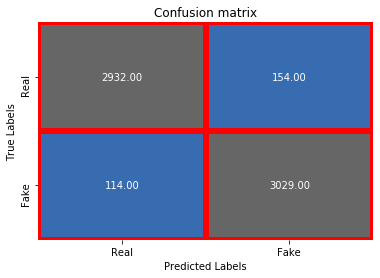

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3086
           1       0.95      0.96      0.96      3143

    accuracy                           0.96      6229
   macro avg       0.96      0.96      0.96      6229
weighted avg       0.96      0.96      0.96      6229



In [48]:
# Train the model
from sklearn.linear_model import PassiveAggressiveClassifier
pac_model = PassiveAggressiveClassifier( validation_fraction=0.25,C=3, max_iter=1000, random_state=42, 
                                         n_iter_no_change=8,
                                         shuffle=True,
                                         loss='hinge',
                                         n_jobs=-1)
pac_model.fit(X_train,y_train)

#Making Prediction
pred = pac_model.predict(X_test)

#Printing the Metrics
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
#Accuracy Score
print('Final score =>', accuracy_score(y_test,pred))

# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0,fmt='.2f',cbar=False,cmap = 'Accent')

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['Real','Fake'])
ax.yaxis.set_ticklabels(['Real','Fake'])
plt.show()

#Classification Report
print(classification_report(y_test,pred))

## Saving the best Model

In [49]:
#Saving this model that is Passive Aggressive Classifier
import joblib

#Save the model as a pickle in a file
joblib.dump(pac,'Fake_News_Detection_TFIDF.csv')

['Fake_News_Detection_TFIDF.csv']